69600
40800
62401
172800
172801
172800


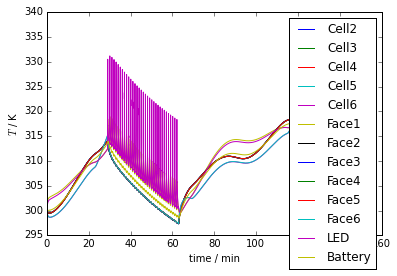

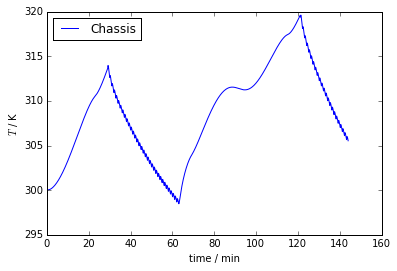

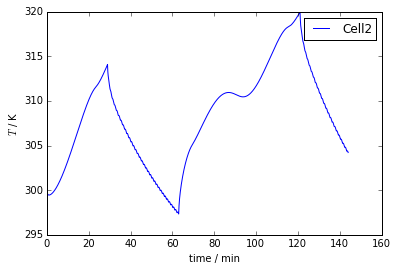

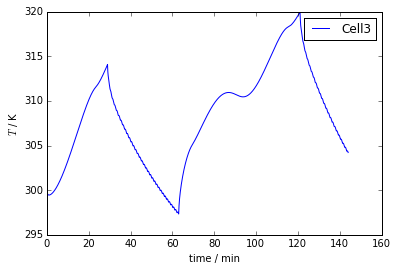

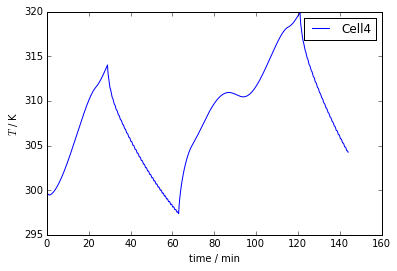

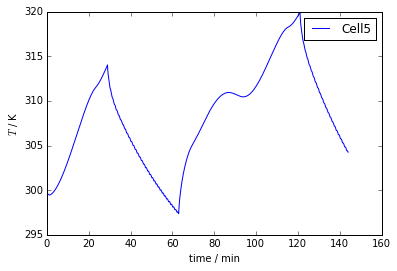

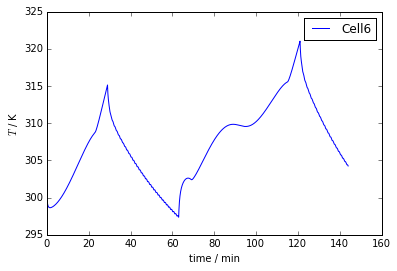

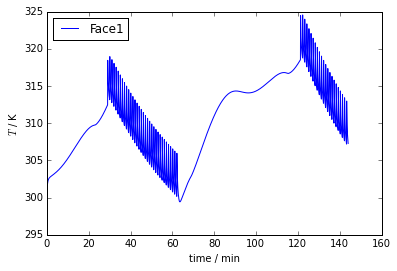

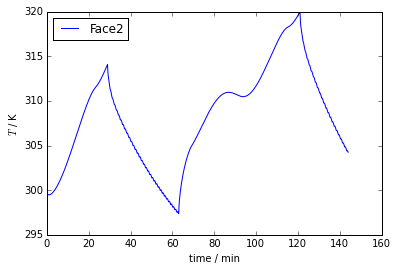

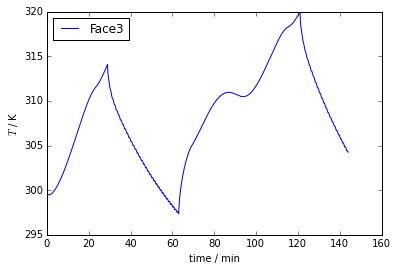

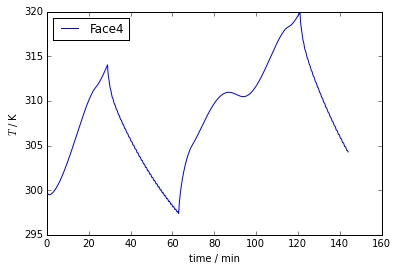

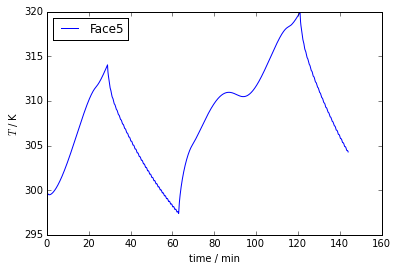

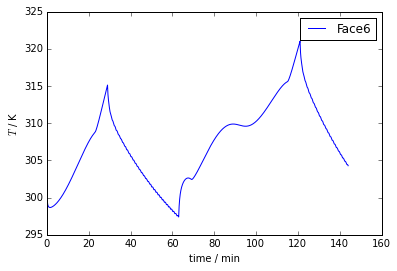

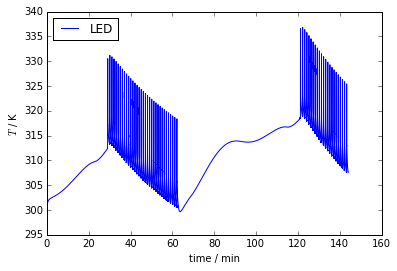

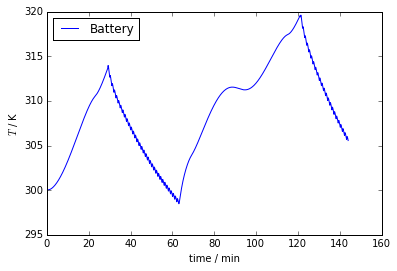

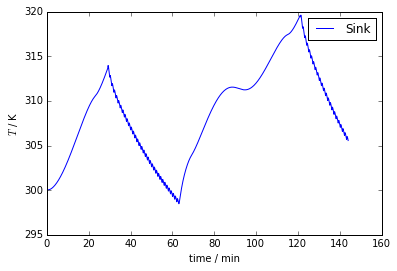

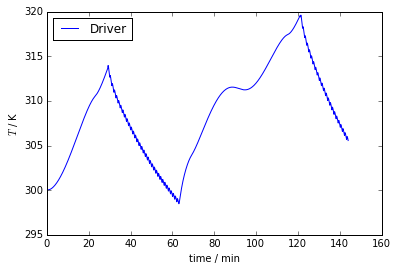

In [2]:
## README ##

'''
This is a nodal thermal model for our 1U CubeSat. It uses an odeint (Ordinary Differential Equation INTegrating function)
to obtain a numerical solution for the temperature of the various nodes as the satellite orbits. Additional nodes can be
added in the function dy_dt(y,t). Just make sure you add them in the unpacking of the vector and the packing of the solution,
as well as defining the actual derivative of the added node (see the way each other node is handled). Make sure that if you
add a connection from one node to another, that the connection is in each differential equation, or suddenly energy is going
to be vanishing from the satellite or being generated out of nowhere.

As for the layout, you can see that the first section is thermal constants, segmented by what part of the system they
pertain to. Then are the various functions (orbit, latitude, orientation, etc.) and the differential equations/solutions,
and then the plotting/graphing section.

If you have questions let me know (finnvankrieken@gmail.com)

Make sure you use this in some sort of shell with iPython (python itself won't work). What I found was simplest was to
download Anaconda Launcher which has iPython Notebook built in, and you can run a notebook locally with whatever web
browser you want. This uses numpy, which is pretty well documented if you need other mathematical functions (just
remember you have to enter them as np.func(x) rather than just func(x))

Happy modeling!

Modeling written by Finn van Krieken, Aaron Charous, and Eddie Williams
'''



'''
 TODO: 
       Biggest: Thermal connectivity b/w pcb/chassis and cell/pcb

       LEDs as node?
       Other satellite elements as nodes (batteries, etc.) + connectivities
       Refined connectivities for PCBs, other boards (especially Face1)
       Update for new cells
       Connection thermal conductivity
'''

from scipy.integrate import odeint
import numpy as np


''' CONSTANTS '''


## Printed Circuit Board (Face)
PCB_abs = .90                      ##  Absorbance
PCB_emis = .90                     ##  Emissivity
PCB_area = 0.01091875              ##  Area -- check this!  GUESS!                    m^2
PCB_thickness = 0.00157            ##  guess Thickness         m
PCB_topmass = 0.055786             ##  Mass                    kg
PCB_sidemass = 0.071455            ##  Mass                    kg
PCB_c = 950                        ##  Spec. heat              J/kgK
PCB_topC = PCB_topmass*PCB_c       ##  Heat capacity           J/K
PCB_sideC = PCB_sidemass*PCB_c     ##  Heat capacity           J/K
PCB_cond = .44                     ##  Thermal conductivity W m^-1 K^-1

## Solar cells: 24 each face

## NOTE: These are the old cells that stopped being produced. This will need to be updated

cell_abs = 0.92                    ##  Absorbance
cell_emis = 0.85                   ##  Emissivity
cell_area = 0.000236207            ##  Area                    m^2
cell_area_eff = 0.0002277          ##  Working Area            m^2
cell_mass = 0.000234               ##  Mass                    kg
cell_c = 800                       ##  Spec. heat              J/kgK
cell_C = cell_mass*cell_c          ##  Heat capacity           J/K
cell_eff = 0.27                    ##  Efficiency of cell      % solar flux converted to electricity
cell_cond = 1666.6666667           ##  Thermal conductivity    W m^-1 K^-1
cell_thickness = 0.00019           ##  Thickness               m

## LED: -- all guessses
led_abs = 0.3                     ##  Absorbance
led_emis = 0.85                   ##  Emissivity
led_area = 0.0006157521601        ##  Area                    m^2
led_mass = 0.000234               ##  Mass                    kg
led_c = 800                       ##  Spec. heat capacity     J/kgK
led_C = led_mass*led_c            ##  Heat capacity           J/K
led_cond = 1                      ##  Thermal conductivity W m^-1 K^-1
led_thickness = 0.00137           ##  Thickness               m

## Chassis:
alum_cond = 167.                   ##  Thermal conductivity W m^-1 K^-1
chassis_mass = 0.21676             ##  Weight                  kg
alum_c = 896.                      ##  Spec. heat              J/kgK
chassis_C = chassis_mass*alum_c    ##  Heat capacity           J/K
chassis_thickness_f_b = 0.0065     ##  Thickness (front/back)  m
chassis_thickness_side = 0.008     ##  Thickness (side)        m
chassis_area = 0.009403            ##  Area                    m^2

## Battery:
battery_cond = 100                 ##  guess Thermal conductivity W m^-1 K^-1
battery_thickness = .05            ## guess thickness             m
battery_area = .2                  ## guess Area                  m
battery_weight = 0.2               ## guess Weight   kg
battery_c = 800                    ##  guess Spec. heat capacity     J/kgK
battery_C = battery_weight*battery_c  ##  Heat capacity           J/K

## Aluminum plate between battery and chassis
plate_cond = alum_cond             ## Thermal conductivity W m^-1 K^-1
plate_thickness = .05              ## guess thickness             m
plate_area = .2                    ## guess Area                  m


## Heat Sink (cellPCB and PCB Chassis are completes guesses)
sink_cond = 6.5                     ##  Thermal conductivity W m^-1 K^-1
sink_thickness = .0025              ## guess Thickness       m
sink_area = 0.001                  ## guess  Area           m^2
sink_weight = 0.1                  ## guess Weight   kg
sink_c = 800                       ##  guess Spec. heat capacity     J/kgK
sink_C = sink_weight*sink_c  ##  Heat capacity           J/K

## LED Driver
driver_cond = 100                 ##  guess Thermal conductivity W m^-1 K^-1
driver_thickness = .05            ## guess thickness             m
driver_area = .2                  ## guess Area                  m
driver_weight = 0.2               ## guess Weight   kg
driver_c = 800                    ##  guess Spec. heat capacity     J/kgK
driver_C = driver_weight*driver_c ##  Heat capacity           J/K
driver_power_dis = 100            ## Heat energy generated by LED Driver    W

## Thermal Resistances                                       K/W
U_Plate = plate_thickness \
            /(plate_area \
            *plate_cond)
U_Battery = plate_thickness \
            /(plate_area \
            *plate_cond)
U_Led = led_thickness \
        /(led_area   \
        *cell_cond)
U_cell = cell_thickness \
            /(cell_area \
            *cell_cond)
U_PCB = PCB_thickness \
        /(PCB_area \
         *PCB_cond)
U_Chassis_f_b = chassis_thickness_f_b \
            /(chassis_area
             *alum_cond)
U_Chassis_side = chassis_thickness_side \
        /(chassis_area
         *alum_cond)
U_sink = sink_thickness \
        /(sink_area
         *sink_cond)
U_Driver = driver_thickness \
            /(driver_area * \
              driver_cond)

## Connections COMPLETE GUESSES RIGHT NOW Thermal Resistance   K/W
U_LedPCB = U_Led + U_PCB
U_cellPCB = U_cell + U_PCB
U_PCBChassis_f_b = U_PCB + U_Chassis_f_b
U_PCBChassis_side = U_PCB + U_Chassis_side
#U_LedSinkChassis = U_Led + \
#                   U_sink + \
#                   U_Chassis_f_b
U_LedSink = U_Led + U_sink
U_BatteryPlateChassis = U_Battery + \
                        U_Plate + \
                        U_Chassis_f_b
U_DriverSink = U_Driver + U_sink
U_SinkChassis = U_sink + U_Chassis_f_b
## Radiation
sigma = 5.67 * 10**(-8)            ##  Boltzman's Constant     W m^-2 K^-4
Tspace = 4.                        ##  Temp of deep space      K
Tearth = 255.                      ##  Temp, not important     K
solar_flux = 1354.                 ##  Sun beams!              W m^-2
albedofactor = .35                 ##  % of solar flux reflected back by earth

## Flash
flash_power_dis = 75              ##  Power dissapated by flash: careful with this. Currently, the odeint integrates over
                                   ##  0.05 second intervals. Make sure the flash time is divisible by .05 (adjust power
                                   ##  accordingly)
b_int_imp= .007                    ## Ohms -- Battery Internal Impedance
b_current = 20                     ## Battery Current Amps
battery_power_dis = b_int_imp* \
                    b_current**2   ##  power dissipated by battery
                                   ##                          W
flash_time = .05                   ##  Time of flash           S
flash_rest = 30                    ##  Time between flashes    S

## Orbit
period = 92                        ##  Time of orbit           min
sun_time = 58                      ##  Time in sun             min
eclipse_time = 34                       ##  Time in eclipse         min

phaseshift = 0                     ##  Minutes into orbit (with zero being directly b/w earth and sun) that satellite
                                   ##  reaches furthest south latitude
                                   ##  Ex: if ps = 23, the satellite would start directly b/w earth and sun at the equator,
                                   ##  then move south as it orbits and reach its furthest south point at 23 minutes in.
                                   ##  at 46 minutes, it would be exactly in the middle of its eclipse and back at the equator


''' FUNCTIONS '''


## rad21: radiation from the second input to the first (net)
## Inputs: T1, temperature of the first object in K
##         T2, temperature of the second object in K
##         a1, absorptivity of the first object
##         e1, emissivity of the first object
## Output: Net energy influx to the first object in W m^-2
def rad21(T1, T2, a1, e1):  ##  W m^-2
    toreturn = a1*sigma*T2**4-e1*sigma*T1**4
    return toreturn

## solar: solar radiation hitting the satellite, taking eclipse into consideration
## Inputs: t, time in minutes
## Output: energy flux hitting the satellite in W m^-2
def solar(t):               ##  W m^-2
    if (((t+29)%period) < sun_time):            ## the 29 is so at t = 0 we are directly
        return solar_flux                       ## between the earth and the sun
    else:
        return 0.

## albedo: albedo radiation (reflected solar radiation) hitting the satellite, taking eclipse into consideration
## Inputs: t, time in minutes
## Output: energy hitting the satellite in W m^-2
def albedo(t):              ##  W m^-2
    return solar(t)*albedofactor

## flash: estimate of heat dissapated from flash panel (assumed to enter flash panel uniformly)
## Inputs: t, time in minutes
## Output: energy dissapated by flash, 3 flashes per orbit when in eclipse.
def flash(t):                    ## W
    realT = t%period
    if (46.0 < realT <= (46+flash_time/60.)) | (47.0 < realT <= (47+flash_time/60.)) | (48.0 < realT <= (48+flash_time/60.)) :
        return flash_power_dis
    else:
        return 0.
    
## eclipse?: determines whether satellite is in eclipse or not, assuming satellite starts btw sun and Earth
## Inputs: t, time in minutes
## Outputs: true if in eclipse, false otherwise
def eclipse(t):
    realT = t%period
    return (29 <= realT <= 63)
    
## betterflash: estimate of heat dissipated from flash panel
## Inputs: t, time in minutes
## Output: energy dissipated by flash, flashes with 30 second interval in between when in eclipse
def betterflash(t):                 ## W
    eclipse_time = t%period - 29 ## time since eclipse started (assuming it is an eclipse)
    flash_period = flash_time + flash_rest ## seconds
    if (eclipse(t) and (eclipse_time%(flash_period/60) == 0)):
        return 1.
    else:
        return 0.
    
    
####### flash new stuff


def squr(t):
    x = 0
    for k in range(1, 100):
        x = x + np.sin((2*k - 1)*np.pi*(t))/(2*k - 1)
    return x

def absrct(y, t):
    return np.abs(rct(y,t))

def rct(y, t):
    a = (t/60.1)*60.0
    b = ((-t + .05)/60.1)*60.0
    rslt = squr(a) + squr(b)
    return rslt

def flashworks(t):
    realT = t%period
    if (29.0 <= realT <= 63.0):
        return absrct(0,t)/1.72
    else:
        return 0.

## phi: refers to angle of orbit around earth, in radians. 0 is between the earth and the sun
## Inputs: t, time in minutes
## Output: phi in radians
def phi(t):
    return 2.*np.pi*(t)/92.

## latitude: refers to angle of inclination, in radians. 0 is between the equator
## Inputs: t, time in minutes
## Output: latitude in radians
def latitude(t):
    toreturn = 51.6*np.pi/180*np.cos(phi(t-phaseshift))
    return toreturn

## theta: refers to angle of inclination, in radians. 0 is between the north pole, 2pi is the south pole
## Inputs: t, time in minutes
## Output: theta in radians
def theta(t):
    return np.pi/2-latitude(t)

## Btheta: refers to the relative strength of the earth's magnetic field in the theta direction 
##         (spherical coordinates, center of earth is origin)
## Inputs: t, time in minutes
## Output: Btheta, in arbitrary units
def Btheta(t):
    toreturn = -(6371./6791.)**3*np.sin(theta(t))
    return toreturn

## Br: refers to the relative strength of the earth's magnetic field in the r direction
## Inputs: t, time in minutes
## Output: Br, in arbitrary units
def Br(t):
    toreturn = -2*(6371./6791.)**3*np.cos(theta(t))
    return toreturn

## CARTESIAN MAGNETIC STRENGTH
## origin is the center of the satellite
## x direction refers to pointing straight away from the sun
## y direction refers to pointing perpendicular to the sun in the same plane as the equator
## z direction refers to pointing perpendicular to the plane of equator

## Bx:
## Inputs: t, time in minutes
## Output: Bx, in arbitrary units
def Bx(t):
    return -(Btheta(t)*np.cos(latitude(t)) + Br(t)*np.sin(latitude(t)))*np.cos(phi(t))

## By:
## Inputs: t, time in minutes
## Output: By, in arbitrary units
def By(t): ##(Horizontal magnitude)
    return -(Btheta(t)*np.cos(latitude(t)) + Br(t)*np.sin(latitude(t)))*np.sin(phi(t))

## Bz:
## Inputs: t, time in minutes
## Output: Bz, in arbitrary units
def Bz(t):
    return (Btheta(t)*np.sin(latitude(t))-Br(t)*np.cos(latitude(t)))

## B_vector: the net vector of the magnetic force of the satellite.
## Inputs: t, time in minutes
## Output: B_vector, in arbitrary units
def B_vector(t):
    return (Bx(t), By(t), Bz(t))

## Face1SunComponent: fraction of solar flux perpendicular to Face1
## Inputs: t, time in minutes
## Output: effective value of solar flux 
def Face1SunComponent(t):
    dx, dy, dz = B_vector(t)
    toreturn = dx/np.sqrt(dx**2+dy**2+dz**2)
    if toreturn < 0:
        return 0
    else:
        return toreturn

## Face6SunComponent: fraction of solar flux perpendicular to Face6
## Inputs: t, time in minutes
## Output: effective value of solar flux 
def Face6SunComponent(t):
    dx, dy, dz = B_vector(t)
    toreturn = -dx/np.sqrt(dx**2+dy**2+dz**2)
    if toreturn < 0:
        return 0
    else:
        return toreturn

## avgFace25SunComponent: average fraction of solar flux perpendicular to Faces 2-5
##                        integrated average over full rotation of satellite about magnetic dipole
## Inputs: t, time in minutes
## Output: effective value of solar flux 
def avgFace25SunComponent(t):
    dx, dy, dz = B_vector(t)
    return np.sqrt((dy**2+dz**2)/(dx**2+dy**2+dz**2))/np.pi
   
## Face1EarthComponent: fraction of albedo radiation perpendicular to Face6
## Inputs: t, time in minutes
## Output: effective value of albedo radiation 
def Face1EarthComponent(t):
    toreturn = -Br(t)/np.sqrt(Br(t)**2+Btheta(t)**2)
    if toreturn < 0:
        return 0
    else:
        return toreturn

## Face6EarthComponent: fraction of albedo radiation perpendicular to Face6
## Inputs: t, time in minutes
## Output: effective value of albedo radiation
def Face6EarthComponent(t):
    toreturn = Br(t)/np.sqrt(Br(t)**2+Btheta(t)**2)
    if toreturn < 0:
        return 0
    else:
        return toreturn

## avgFace25EarthComponent: average fraction of albedo radiation perpendicular to Faces 2-5
##                          integrated average over full rotation of satellite about magnetic dipole
## Inputs: t, time in minutes
## Output: effective value of albedo radiation 
def avgFace25EarthComponent(t):
    return np.absolute(Btheta(t))/np.sqrt(Br(t)**2+Btheta(t)**2)/np.pi
    
    
''' DIFFERENTIAL EQUATIONS '''


## Each panel and set of cells on a panel are nodes, as is the chassis. They each have their own thermal pathways,
## with radiation and conduction between adjacent nodes. If you aren't sure 
def dy_dt(y, t): 
    #Face1 is flash
    #Face6 is opposite flash
    #Face2 and Face3 are top/bottom
    Led, Cell2, Cell3, Cell4, Cell5, Cell6, Face1, Face2, Face3, Face4, Face5, Face6, Chassis, Battery, Sink, Driver = y  # Unpack the vector.
    dLed_dt = (rad21(Led, Tspace, led_abs, led_emis) * led_area + \
                 solar(t) * led_abs * led_area* Face1SunComponent(t) + \
                 albedo(t) * led_area * led_abs * Face1EarthComponent(t) + \
                 + flash_power_dis * flashworks(t) + \
                 (1./U_LedPCB) * (Face1 - Led) + \
                 (1./U_LedSink) * (Sink - Led)) \
                * 60 / led_C
    dCell2_dt = (rad21(Cell2, Tspace, cell_abs, cell_emis) * cell_area + \
                 solar(t) * cell_abs * (cell_area - cell_eff * cell_area_eff) * avgFace25SunComponent(t) + \
                 albedo(t) * cell_area * cell_abs * avgFace25EarthComponent(t) + \
                 (1./U_cellPCB) * (Face2 - Cell2)) \
                * 60 / cell_C
    dCell3_dt = (rad21(Cell3, Tspace, cell_abs, cell_emis) * cell_area + \
                 solar(t) * cell_abs * (cell_area - cell_eff * cell_area_eff) * avgFace25SunComponent(t) + \
                 albedo(t) * cell_area * cell_abs * avgFace25EarthComponent(t) + \
                 (1./U_cellPCB) * (Face3 - Cell3)) \
                * 60 / cell_C
    dCell4_dt = (rad21(Cell4, Tspace, cell_abs, cell_emis) * cell_area + \
                 solar(t) * cell_abs * (cell_area - cell_eff * cell_area_eff) * avgFace25SunComponent(t) + \
                 albedo(t) * cell_area * cell_abs * avgFace25EarthComponent(t) + \
                 (1./U_cellPCB) * (Face4 - Cell4)) \
                * 60 / cell_C
    dCell5_dt = (rad21(Cell5, Tspace, cell_abs, cell_emis) * cell_area + \
                 solar(t) * cell_abs * (cell_area - cell_eff * cell_area_eff) * avgFace25SunComponent(t) + \
                 albedo(t) * cell_area * cell_abs * avgFace25EarthComponent(t) + \
                 (1./U_cellPCB) * (Face5 - Cell5)) \
                * 60 / cell_C
    dCell6_dt = (rad21(Cell6, Tspace, cell_abs, cell_emis) * cell_area + \
                 solar(t) * cell_abs * (cell_area - cell_eff * cell_area_eff) * Face6SunComponent(t) + \
                 albedo(t) * cell_area * cell_abs * Face6EarthComponent(t) + \
                 (1./U_cellPCB) * (Face6 - Cell6)) \
                * 60 / cell_C
    dFace1_dt = (rad21(Face1, Tearth, PCB_abs, PCB_emis)*(PCB_area - 4*led_area) + \
                 solar(t) * PCB_abs * (PCB_area - led_area) * Face1SunComponent(t) + \
                 albedo(t) * PCB_abs * (PCB_area - led_area) * Face1EarthComponent(t) + \
                 4 * (1./U_LedPCB) * (Led - Face1) + \
                 (1./U_PCBChassis_f_b) * (Chassis - Face1)) \
                * 60 / PCB_sideC
    dFace2_dt = (rad21(Face2, Tspace, PCB_abs, PCB_emis) * (PCB_area - 24. * cell_area) + \
                 solar(t) * PCB_abs * (PCB_area) * avgFace25SunComponent(t) + \
                 albedo(t) * PCB_abs * PCB_area * avgFace25EarthComponent(t) + \
                 24. * (1./U_cellPCB) * (Cell2 - Face2) + \
                 (1./U_PCBChassis_side) * (Chassis - Face2)) \
                * 60 / PCB_topC
    dFace3_dt = (rad21(Face3, Tspace, PCB_abs, PCB_emis) * (PCB_area - 24. * cell_area) + \
                 solar(t) * PCB_abs * (PCB_area) * avgFace25SunComponent(t) + \
                 albedo(t) * PCB_abs * PCB_area * avgFace25EarthComponent(t) + \
                 24. * (1./U_cellPCB) * (Cell3 - Face3) + \
                 (1./U_PCBChassis_side) * (Chassis - Face3)) \
                * 60 / PCB_topC
    dFace4_dt = (rad21(Face4, Tspace, PCB_abs, PCB_emis) * (PCB_area - 24. * cell_area) + \
                 solar(t) * PCB_abs * (PCB_area) * avgFace25SunComponent(t) + \
                 albedo(t) * PCB_abs * PCB_area * avgFace25EarthComponent(t) + \
                 24. * (1./U_cellPCB) * (Cell4 - Face4) + \
                 (1./U_PCBChassis_side) * (Chassis - Face4)) \
                * 60 / PCB_sideC
    dFace5_dt = (rad21(Face5, Tspace, PCB_abs, PCB_emis) * (PCB_area - 24. * cell_area) + \
                 solar(t) * PCB_abs * (PCB_area) * avgFace25SunComponent(t) + \
                 albedo(t) * PCB_abs * PCB_area * avgFace25EarthComponent(t) + \
                 24. * (1./U_cellPCB) * (Cell5 - Face5) + \
                 (1./U_PCBChassis_side) * (Chassis - Face5)) \
                * 60 / PCB_sideC
    dFace6_dt = (rad21(Face6, Tspace, PCB_abs, PCB_emis) * (PCB_area - 24. * cell_area) + \
                 solar(t) * PCB_abs * (PCB_area) * Face6SunComponent(t) + \
                 albedo(t) * PCB_abs * PCB_area * Face6EarthComponent(t) + \
                 24. * (1./U_cellPCB) * (Cell6 - Face6) + \
                 (1./U_PCBChassis_f_b) * (Chassis - Face6)) \
                * 60 / PCB_sideC
    dChassis_dt = ((1./U_PCBChassis_f_b) * (Face1 + Face6 - 2* Chassis) + \
                   (1./U_PCBChassis_side) * (Face2 + Face3 + Face4 + Face5 - 4* Chassis) + \
                  (1./U_BatteryPlateChassis) * (Battery - Chassis) + \
                   (1./U_SinkChassis) * (Sink - Chassis)) \
                  * 60 / chassis_C
    dBattery_dt = (battery_power_dis * flashworks(t) + \
                  (1./U_BatteryPlateChassis) * (Chassis - Battery)) \
                * 60 / battery_C
    dSink_dt = ((1./U_SinkChassis) * (Chassis - Sink) + \
               4*(1./U_LedSink) * (Led - Sink) + \
               (1./U_DriverSink) * (Driver - Sink)) * 60 / sink_C
    dDriver_dt = (driver_power_dis * flashworks(t) + \
                (1./U_DriverSink) * (Sink - Driver)) * 60 / driver_C
    dydt = [dLed_dt, dCell2_dt, dCell3_dt, dCell4_dt, dCell5_dt, dCell6_dt, dFace1_dt, dFace2_dt, dFace3_dt, dFace4_dt, dFace5_dt, dFace6_dt, dChassis_dt, dBattery_dt, dSink_dt, dDriver_dt]  # Pack the answer.
    return dydt

days = .1                   ## specify number of days that the odeint should run. Keep in under 0.5 if you want reasonable run time
y0s = np.zeros(16)
for i in range(0, 16):
    y0s[i] = 300.           ## estimate for average psuedo steady-state temperature
times = np.linspace(start=0., stop=24*60*days, num=24*60*days*60*20) ## (starting time, stopping time, number of increments)
#answer = odeint(func=dy_dt, y0=y0s, t=times)

def connect(y0, t0, end_time):
    if eclipse(t0):
        stop_time = t0 + eclipse_time
    else:
        stop_time = t0 + sun_time
    if end_time < stop_time:
        stop_time = end_time + 1/1200
    orbittimes = np.linspace(start=t0, stop=stop_time, num=60*(stop_time - t0)*20)
    sol = odeint(func=dy_dt, y0=y0, t=orbittimes)
    return sol, stop_time, sol[len(sol) - 1]

def runconnect(num_days):
    end_time = num_days * 24 * 60
    previous_sol, stop_time, last_val = connect(y0s, 0, end_time)
    print(len(previous_sol[:,0]))
    combined_solution = previous_sol
    while end_time > stop_time:
        previous_sol, stop_time, last_val = connect(last_val, stop_time, end_time)
        print(len(previous_sol[:,0]))
        combined_solution = np.concatenate((combined_solution, previous_sol), axis = 0)
        
    return combined_solution

answer = runconnect(days)
print(len(times))
print(len(answer[:,0]))
if len(times) < len(answer[:,0]):
    answer = answer[0:len(times),:]
print(len(answer))

''' GRAPHING '''

## the rest is plotting. I tried to figure out a way to make it a little more elegant but ran into syntax problems

Led = answer[:, 0]
Cell2 = answer[:, 1]
Cell3 = answer[:, 2]
Cell4 = answer[:, 3]
Cell5 = answer[:, 4]
Cell6 = answer[:, 5]
Face1 = answer[:, 6]
Face2 = answer[:, 7]
Face3 = answer[:, 8]
Face4 = answer[:, 9]
Face5 = answer[:, 10]
Face6 = answer[:, 11]
Chassis = answer[:, 12]
Battery = answer[:, 13]
Sink = answer[:, 14]
Driver = answer[:, 15]

from matplotlib import pyplot
%matplotlib inline
fig = pyplot.figure()
ax = fig.add_subplot(111)
ax.plot(times, Cell2, label='Cell2')
ax.plot(times, Cell3, label='Cell3')
ax.plot(times, Cell4, label='Cell4')
ax.plot(times, Cell5, label='Cell5')
ax.plot(times, Cell6, label='Cell6')
ax.plot(times, Face1, label='Face1')
ax.plot(times, Face2, label='Face2')
ax.plot(times, Face3, label='Face3')
ax.plot(times, Face4, label='Face4')
ax.plot(times, Face5, label='Face5')
ax.plot(times, Face6, label='Face6')
ax.plot(times, Led, label = 'LED')
ax.plot(times, Battery, label = 'Battery')
ax.legend(loc='best')
ax.set_xlabel('time / min')
ax.set_ylabel('$T$ / K')
fig1 = pyplot.figure()
ax = fig1.add_subplot(111)
ax.plot(times, Chassis, label='Chassis')
ax.legend(loc='best')
ax.set_xlabel('time / min')
ax.set_ylabel('$T$ / K')
fig2 = pyplot.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(times, Cell2, label='Cell2')
ax2.legend(loc='best')
ax2.set_xlabel('time / min')
ax2.set_ylabel('$T$ / K')
fig3 = pyplot.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(times, Cell3, label='Cell3')
ax3.legend(loc='best')
ax3.set_xlabel('time / min')
ax3.set_ylabel('$T$ / K')
fig4 = pyplot.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(times, Cell4, label='Cell4')
ax4.legend(loc='best')
ax4.set_xlabel('time / min')
ax4.set_ylabel('$T$ / K')
fig5 = pyplot.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(times, Cell5, label='Cell5')
ax5.legend(loc='best')
ax5.set_xlabel('time / min')
ax5.set_ylabel('$T$ / K')
fig6 = pyplot.figure()
ax6 = fig6.add_subplot(111)
ax6.plot(times, Cell6, label='Cell6')
ax6.legend(loc='best')
ax6.set_xlabel('time / min')
ax6.set_ylabel('$T$ / K')
fig11 = pyplot.figure()
ax11 = fig11.add_subplot(111)
ax11.plot(times, Face1, label='Face1')
ax11.legend(loc='best')
ax11.set_xlabel('time / min')
ax11.set_ylabel('$T$ / K')
fig12 = pyplot.figure()
ax12 = fig12.add_subplot(111)
ax12.plot(times, Face2, label='Face2')
ax12.legend(loc='best')
ax12.set_xlabel('time / min')
ax12.set_ylabel('$T$ / K')
fig13 = pyplot.figure()
ax13 = fig13.add_subplot(111)
ax13.plot(times, Face3, label='Face3')
ax13.legend(loc='best')
ax13.set_xlabel('time / min')
ax13.set_ylabel('$T$ / K')
fig14 = pyplot.figure()
ax14 = fig14.add_subplot(111)
ax14.plot(times, Face4, label='Face4')
ax14.legend(loc='best')
ax14.set_xlabel('time / min')
ax14.set_ylabel('$T$ / K')
fig15 = pyplot.figure()
ax15 = fig15.add_subplot(111)
ax15.plot(times, Face5, label='Face5')
ax15.legend(loc='best')
ax15.set_xlabel('time / min')
ax15.set_ylabel('$T$ / K')
fig16 = pyplot.figure()
ax16 = fig16.add_subplot(111)
ax16.plot(times, Face6, label='Face6')
ax16.legend(loc='best')
ax16.set_xlabel('time / min')
ax16.set_ylabel('$T$ / K')
fig17 = pyplot.figure()
ax17 = fig17.add_subplot(111)
ax17.plot(times, Led, label='LED')
ax17.legend(loc='best')
ax17.set_xlabel('time / min')
ax17.set_ylabel('$T$ / K')
fig18 = pyplot.figure()
ax18 = fig18.add_subplot(111)
ax18.plot(times, Battery, label='Battery')
ax18.legend(loc='best')
ax18.set_xlabel('time / min')
ax18.set_ylabel('$T$ / K')
fig19 = pyplot.figure()
ax19 = fig19.add_subplot(111)
ax19.plot(times, Battery, label='Sink')
ax19.legend(loc='best')
ax19.set_xlabel('time / min')
ax19.set_ylabel('$T$ / K')
fig20 = pyplot.figure()
ax20 = fig20.add_subplot(111)
ax20.plot(times, Battery, label='Driver')
ax20.legend(loc='best')
ax20.set_xlabel('time / min')
ax20.set_ylabel('$T$ / K')
full_output = 1  ## this makes it keep running no matter how long it takes (because the odeint solver can take a bit)